# Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pylab
import seaborn as sns
import gc
from scipy.stats import boxcox

# Load Data

In [4]:
cols = ["Severity","Start_Time","Start_Lat","Start_Lng","Distance(mi)","State","Timezone","Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure(in)","Visibility(mi)","Wind_Direction","Wind_Speed(mph)","Precipitation(in)","Weather_Condition","Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop","Sunrise_Sunset","Civil_Twilight","Nautical_Twilight","Astronomical_Twilight"]
data = pd.read_csv('data/US_Accidents_March23.csv', usecols=cols)
print("The shape of data is:",(data.shape))
display(data.head(3))

The shape of data is: (7728394, 33)


,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),State,Timezone,Temperature(F),Wind_Chill(F),Humidity(%),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,3,2016-02-08 05:46:00,39.865147,-84.058723,0.01,OH,US/Eastern,36.9,NaN,91.0,...,False,False,False,False,False,False,Night,Night,Night,Night
1,2,2016-02-08 06:07:59,39.928059,-82.831184,0.01,OH,US/Eastern,37.9,NaN,100.0,...,False,False,False,False,False,False,Night,Night,Night,Day
2,2,2016-02-08 06:49:27,39.063148,-84.032608,0.01,OH,US/Eastern,36.0,33.3,100.0,...,False,False,False,False,True,False,Night,Night,Day,Day


# Preprocessing

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 33 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Severity               int64  
 1   Start_Time             object 
 2   Start_Lat              float64
 3   Start_Lng              float64
 4   Distance(mi)           float64
 5   State                  object 
 6   Timezone               object 
 7   Temperature(F)         float64
 8   Wind_Chill(F)          float64
 9   Humidity(%)            float64
 10  Pressure(in)           float64
 11  Visibility(mi)         float64
 12  Wind_Direction         object 
 13  Wind_Speed(mph)        float64
 14  Precipitation(in)      float64
 15  Weather_Condition      object 
 16  Amenity                bool   
 17  Bump                   bool   
 18  Crossing               bool   
 19  Give_Way               bool   
 20  Junction               bool   
 21  No_Exit                bool   
 22  Railway           

In [6]:
# fix datetime type
data['Start_Time'] = pd.to_datetime(data['Start_Time'],format="ISO8601")


data['Year'] = data['Start_Time'].dt.year
data['Month'] = data['Start_Time'].dt.month
data['Day'] = data['Start_Time'].dt.day
data['Hour'] = data['Start_Time'].dt.hour
data['Week'] = data['Start_Time'].dt.weekday

data.drop(['Start_Time'], axis=1, inplace=True)

In [7]:
missing = pd.DataFrame(data.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Percent(%)']
missing['Missing_Percent(%)'] = missing['Missing_Percent(%)'].apply(lambda x: x / data.shape[0] * 100)
missing.loc[missing['Missing_Percent(%)']>0,:]

,Feature,Missing_Percent(%)
5,Timezone,0.101030
6,Temperature(F),2.120143
7,Wind_Chill(F),25.865904
8,Humidity(%),2.253301
9,Pressure(in),1.820288
10,Visibility(mi),2.291524
11,Wind_Direction,2.267043
12,Wind_Speed(mph),7.391355
13,Precipitation(in),28.512858
14,Weather_Condition,2.244438


In [8]:
data = data.dropna(subset=['Wind_Direction','Visibility(mi)','Pressure(in)','Humidity(%)',"Civil_Twilight","Nautical_Twilight","Astronomical_Twilight",
                       'Sunrise_Sunset','Weather_Condition'])

Text(0.5, 0.98, 'Analyzing distribution')

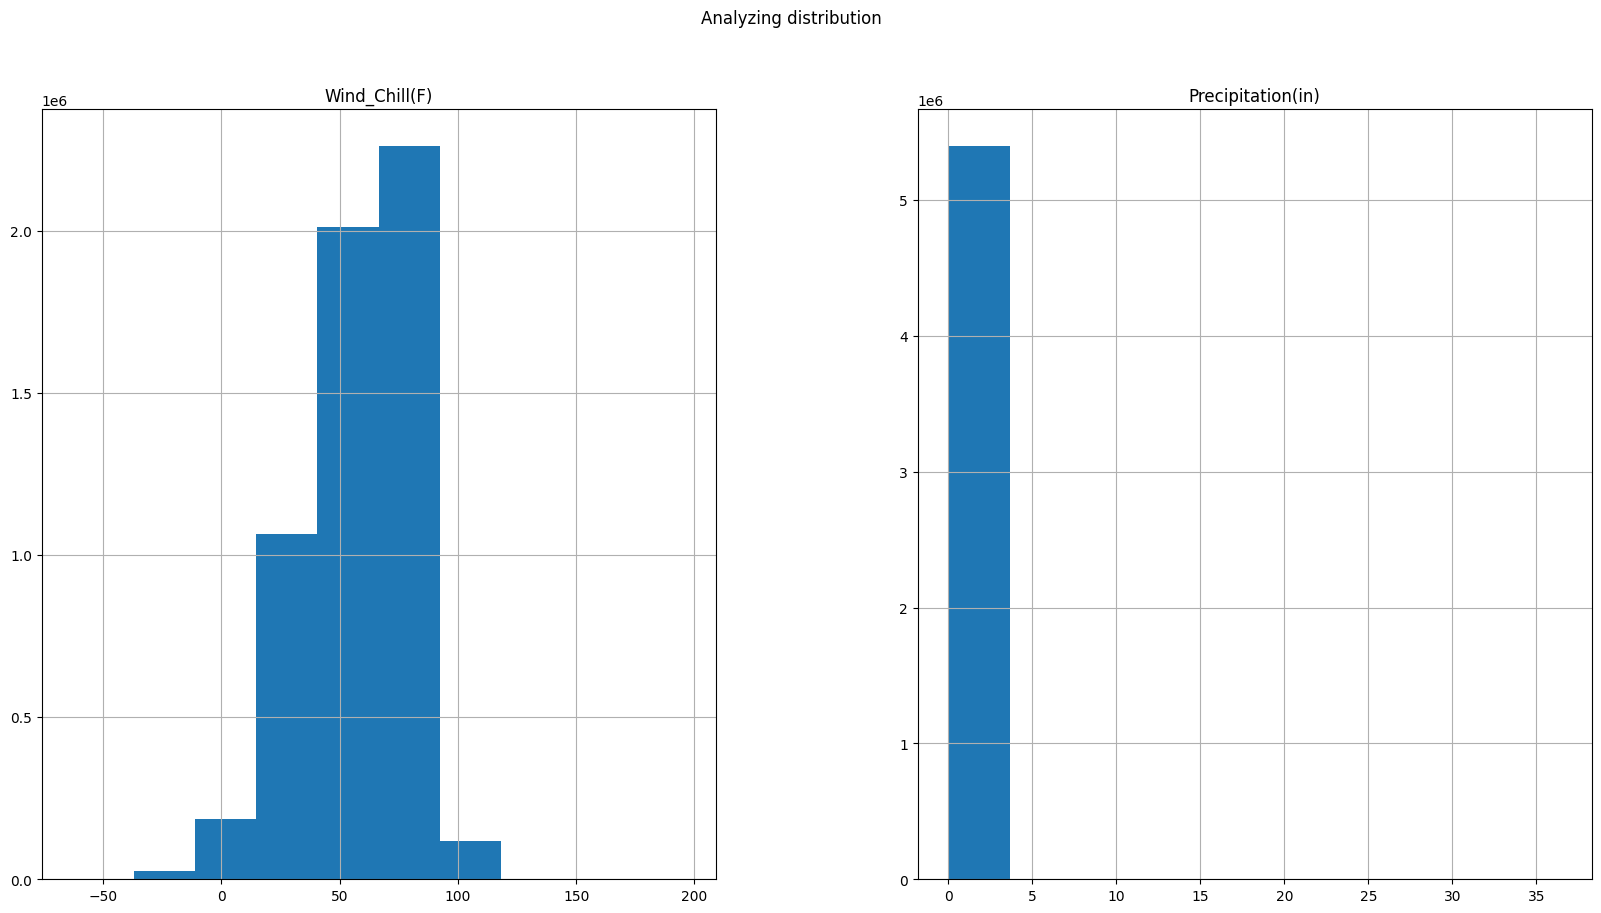

In [9]:
data.hist(
    column=['Wind_Chill(F)', 'Precipitation(in)'],
    figsize=(20, 10)
)
pylab.suptitle("Analyzing distribution", fontsize="large")

In [10]:
data = data.drop(['Precipitation(in)'], axis=1)

In [11]:
data = data.dropna(subset=['Wind_Chill(F)'])

In [12]:
missing = pd.DataFrame(data.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Percent(%)']
missing['Missing_Percent(%)'] = missing['Missing_Percent(%)'].apply(lambda x: x / data.shape[0] * 100)
missing.loc[missing['Missing_Percent(%)']>0,:]

,Feature,Missing_Percent(%)


In [13]:
print("The shape of data is:",(data.shape))

The shape of data is: (5667054, 36)


In [14]:
print("Wind Direction: ", data['Wind_Direction'].unique())

Wind Direction:  ['SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'Variable' 'North'
 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' 'S' 'VAR' 'CALM' 'N']


<Axes: xlabel='Wind_Direction'>

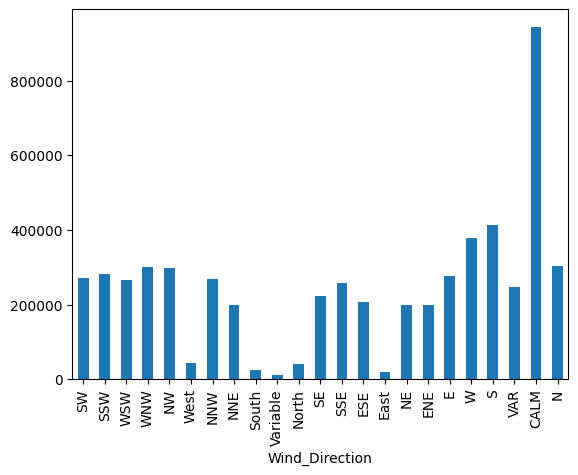

In [15]:
pd.Series(data['Wind_Direction']).value_counts(sort=False).plot(kind='bar')

In [16]:
data.loc[data['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
data.loc[(data['Wind_Direction']=='West')|(data['Wind_Direction']=='WSW')|(data['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
data.loc[(data['Wind_Direction']=='South')|(data['Wind_Direction']=='SSW')|(data['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
data.loc[(data['Wind_Direction']=='North')|(data['Wind_Direction']=='NNW')|(data['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
data.loc[(data['Wind_Direction']=='East')|(data['Wind_Direction']=='ESE')|(data['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
data = data[(data["Wind_Direction"].str.contains('VAR') |data["Wind_Direction"].str.contains('Variable'))== False]
print("Wind Direction after simplification: ", data['Wind_Direction'].unique())

Wind Direction after simplification:  ['SW' 'S' 'W' 'NW' 'N' 'SE' 'E' 'NE' 'CALM']


In [17]:
weather ='!'.join(data['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin\AppData\Local\Temp\ipykernel_2988\253030921.py:3: SyntaxWarning: invalid escape sequence '\s'
  "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()


Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drifting Snow', 'Drizzle', 'Dust', 'Dust Whirls Nearby', 'Dust Whirlwinds', 'Fair', 'Fog', 'Funnel Cloud', 'Hail', 'Haze', 'Heavy ', 'Heavy Drizzle', 'Heavy Ice Pellets', 'Heavy Rain', 'Heavy Rain Shower', 'Heavy Sleet', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Fog', 'Light Hail', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Grains', 'Light Snow Shower', 'Light Snow Showers', 'Light Thunderstorms', 'Low Drifting Snow', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Shower', 'Rain Showers', 'Sand', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'Snow Grains', 'Snow Nearby', 'Snow Showers', 'Squalls', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms', 'Tornado', 'Widespread Dust', 'Wi

In [18]:
data.loc[(data['Weather_Condition'].str.contains('Clear')|data['Weather_Condition'].str.contains('Fair')),'Weather_Condition']='Clear'
data.loc[(data['Weather_Condition'].str.contains('Cloud')|data['Weather_Condition'].str.contains('Overcast')),'Weather_Condition']='Cloud'
data.loc[(data['Weather_Condition'].str.contains('Rain')|data['Weather_Condition'].str.contains('Drizzle')|data['Weather_Condition'].str.contains('Showers in the Vicinity')),'Weather_Condition']='Rain'
data.loc[(data['Weather_Condition'].str.contains('Dust')|data['Weather_Condition'].str.contains('Smoke')|data['Weather_Condition'].str.contains('Sand')|data['Weather_Condition'].str.contains('Ash')),'Weather_Condition']='Dust'
data.loc[(data['Weather_Condition'].str.contains('Heavy Rain')|data['Weather_Condition'].str.contains('Rain Shower')|data['Weather_Condition'].str.contains('T-Storm')|data['Weather_Condition'].str.contains('Thunder')|data['Weather_Condition'].str.contains('Tornado')),'Weather_Condition']='Heavy_Rain'
data.loc[(data['Weather_Condition'].str.contains('Hail')|data['Weather_Condition'].str.contains('Snow')|data['Weather_Condition'].str.contains('Sleet')|data['Weather_Condition'].str.contains('Wintry')|data['Weather_Condition'].str.contains('Ice')),'Weather_Condition']='Snow'
data.loc[(data['Weather_Condition'].str.contains('Heavy Snow')|data['Weather_Condition'].str.contains('Heavy Sleet')|data['Weather_Condition'].str.contains('Heavy Ice Pellets')|data['Weather_Condition'].str.contains('Snow Showers')|data['Weather_Condition'].str.contains('Squalls')|data['Weather_Condition'].str.contains('Wintry')),'Weather_Condition']='Heavy_Snow'
data.loc[(data['Weather_Condition'].str.contains('Fog')|data['Weather_Condition'].str.contains('Mist')|data['Weather_Condition'].str.contains('Haze')),'Weather_Condition']='Fog'
#More to do here

data = data[data['Weather_Condition'] != ""]
data = data[data['Weather_Condition'] != "N/A Precipitation"]

weather ='!'.join(data['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin\AppData\Local\Temp\ipykernel_2988\1063879987.py:16: SyntaxWarning: invalid escape sequence '\s'
  "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()


Weather Conditions:  ['Clear', 'Cloud', 'Dust', 'Fog', 'Heavy_Rain', 'Heavy_Snow', 'Rain', 'Snow']


# Insights

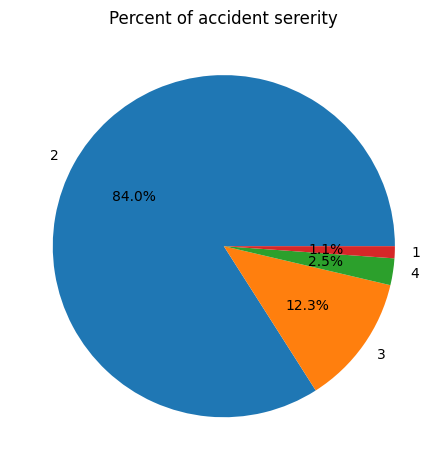

In [19]:
s = data['Severity'].value_counts()
plt.pie(s,labels = s.index,
        autopct='%1.1f%%',
        startangle=0)
plt.title("Percent of accident sererity")
plt.tight_layout()
plt.show()

In [20]:
data.Severity.value_counts()
data.loc[(data['Severity'] <= 2), 'Severity'] = 0
data.loc[(data['Severity'] >= 3), 'Severity'] = 1

data.Severity.value_counts()

Severity
0    4603657
1     802045
Name: count, dtype: int64

In [21]:
def resampleData(df,col,n=10000):
  return pd.concat([df[df[col]==1].sample(n, replace = True),
                   df[df[col]==0].sample(n)], axis=0)

In [22]:
re_df = resampleData(data,'Severity',1000000)
print("Resample Data: ",re_df.Severity.value_counts())

Resample Data:  Severity
1    1000000
0    1000000
Name: count, dtype: int64


Let's Explore the data

## Time Feature

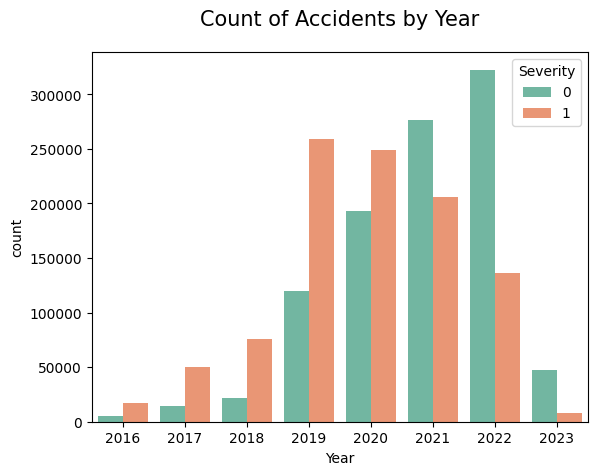

In [23]:
sns.countplot(x='Year', hue='Severity', data= re_df,palette="Set2")
plt.title('Count of Accidents by Year', size=15, y=1.05)
plt.show()

In [24]:
data = data.loc[data['Year'] >= 2019]
data['Severity'].value_counts()

re_df = resampleData(data,'Severity',800000)

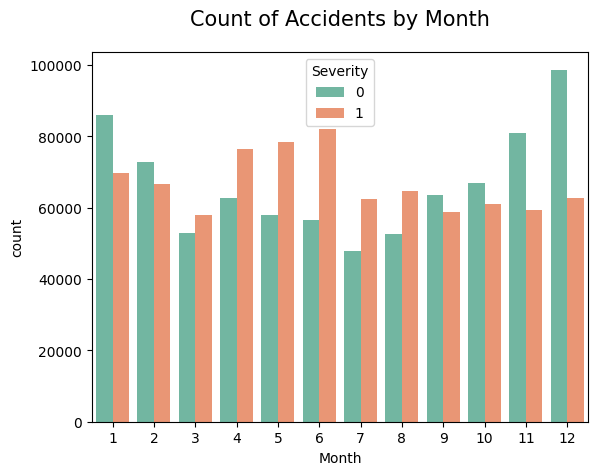

In [25]:
sns.countplot(x='Month', hue='Severity', data = re_df,palette="Set2")
plt.title('Count of Accidents by Month', size=15, y=1.05)
plt.show()

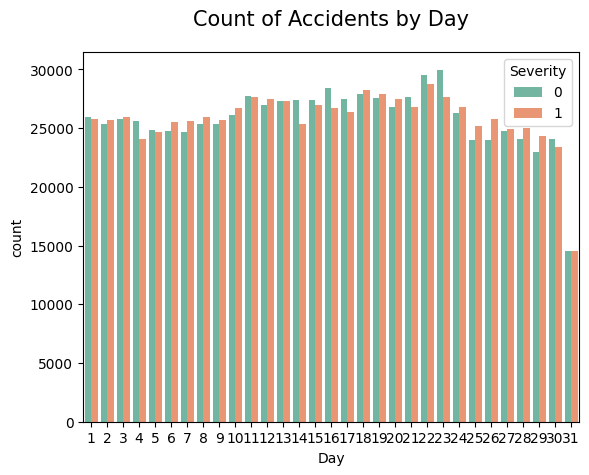

In [26]:
sns.countplot(x='Day', hue='Severity', data= re_df,palette="Set2")
plt.title('Count of Accidents by Day', size=15, y=1.05)
plt.show()

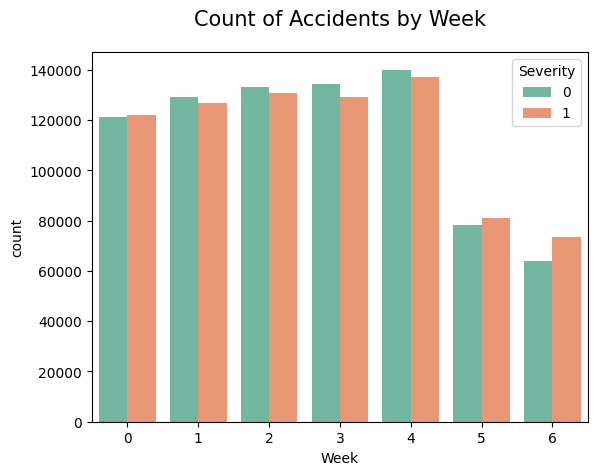

In [27]:
sns.countplot(x='Week', hue='Severity', data= re_df,palette="Set2")
plt.title('Count of Accidents by Week', size=15, y=1.05)
plt.show()

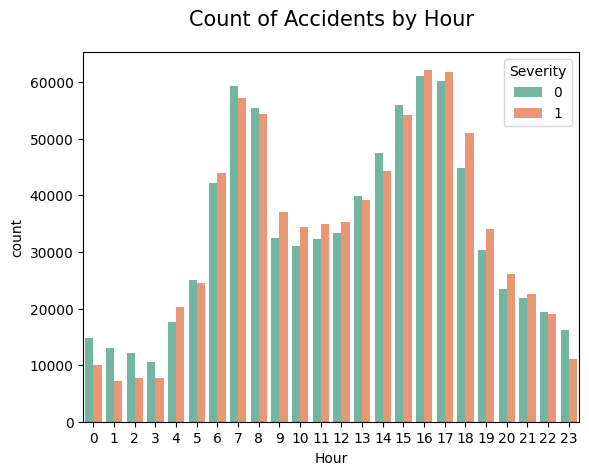

In [28]:
sns.countplot(x='Hour', hue='Severity', data= re_df,palette="Set2")
plt.title('Count of Accidents by Hour', size=15, y=1.05)
plt.show()

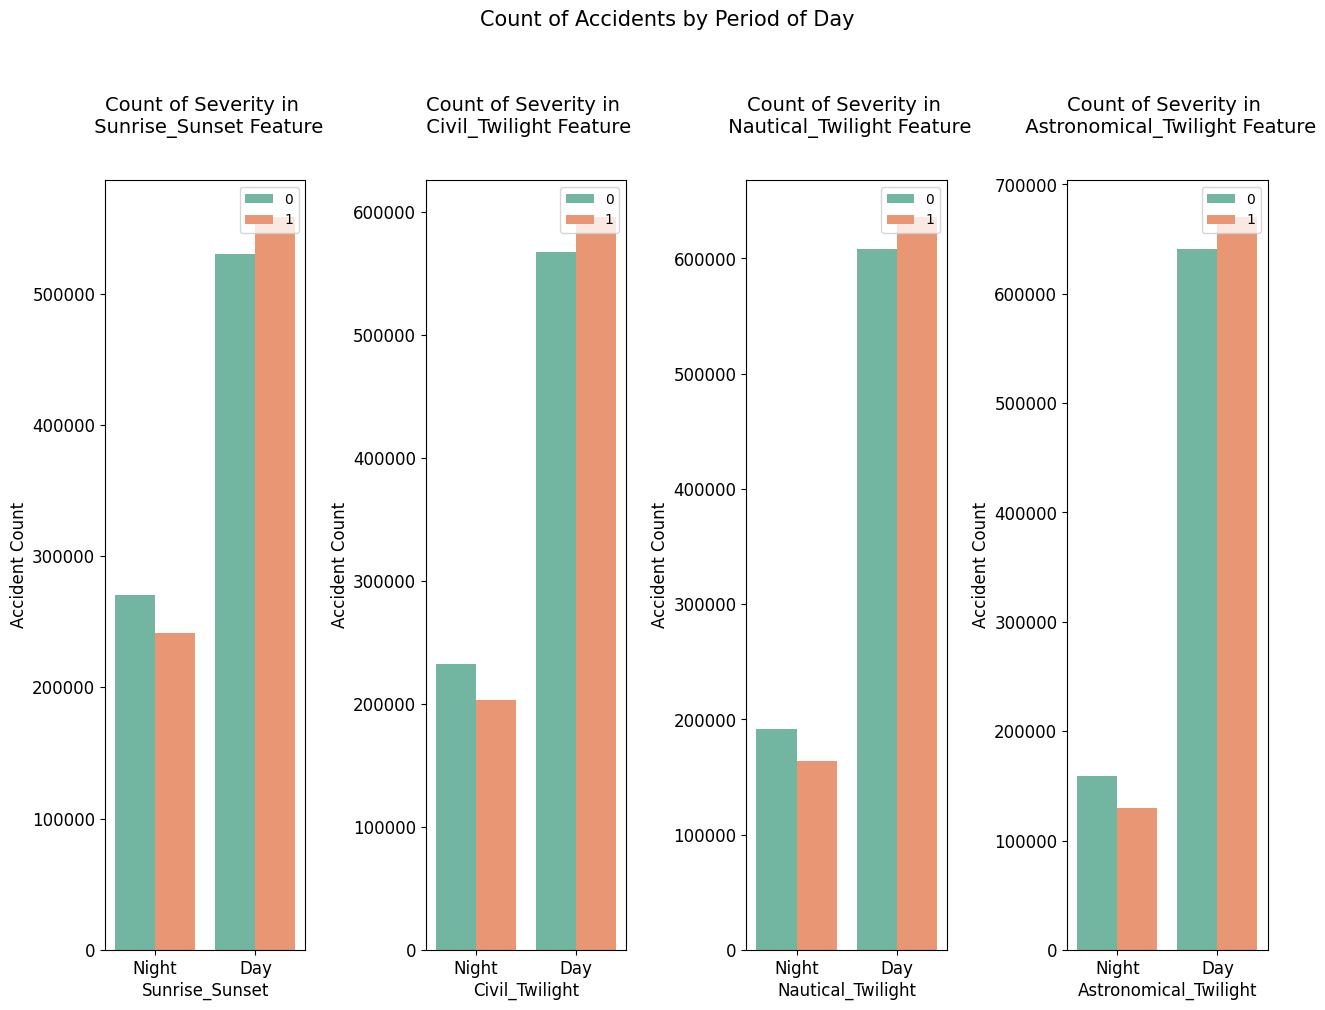

In [29]:
# Assuming `data` is your DataFrame and has 'Weather_Condition' and 'Severity' columns.
period_of_day = ['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']


fig, axs = plt.subplots(1, 4, figsize=(15, 10))  # Create a 3x3 grid
plt.subplots_adjust(hspace=0.4, wspace=0.6)      # Adjust spacing

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot for each feature
for i, feature in enumerate(period_of_day):
    re_df = re_df.reset_index(drop=True)

    # Create a countplot in the current axis
    sns.countplot(ax=axs[i], x = feature, hue='Severity', data=re_df, palette="Set2")

    axs[i].set_xlabel(f'{feature}', size=12, labelpad=3)
    axs[i].set_ylabel('Accident Count', size=12, labelpad=3)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].legend(['0', '1'], loc='upper right', prop={'size': 10})
    axs[i].set_title(f'Count of Severity in \n {feature} Feature', size=14, y=1.05)

# Hide unused subplots
for j in range(len(weather), len(axs)):
    fig.delaxes(axs[j])

# Add a global title
fig.suptitle('Count of Accidents by Period of Day', fontsize=15,y=1.05)
plt.show()

In [30]:
data = data.drop(['Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], axis=1)

## Location Feature

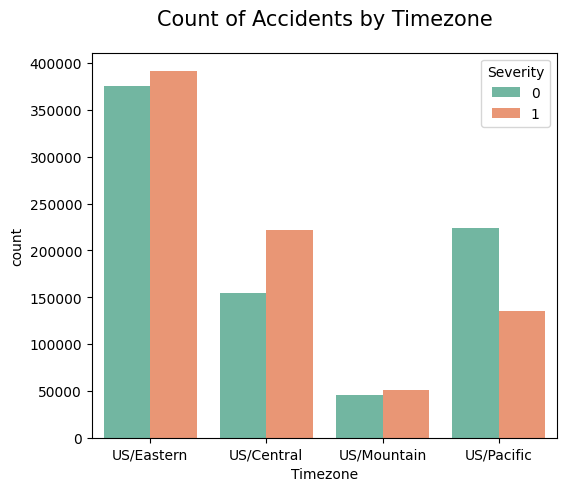

In [31]:
plt.figure(figsize=(6,5))
sns.countplot(x='Timezone', hue='Severity', data=re_df ,palette="Set2")
plt.title("Count of Accidents by Timezone", size=15, y=1.05)
plt.show()

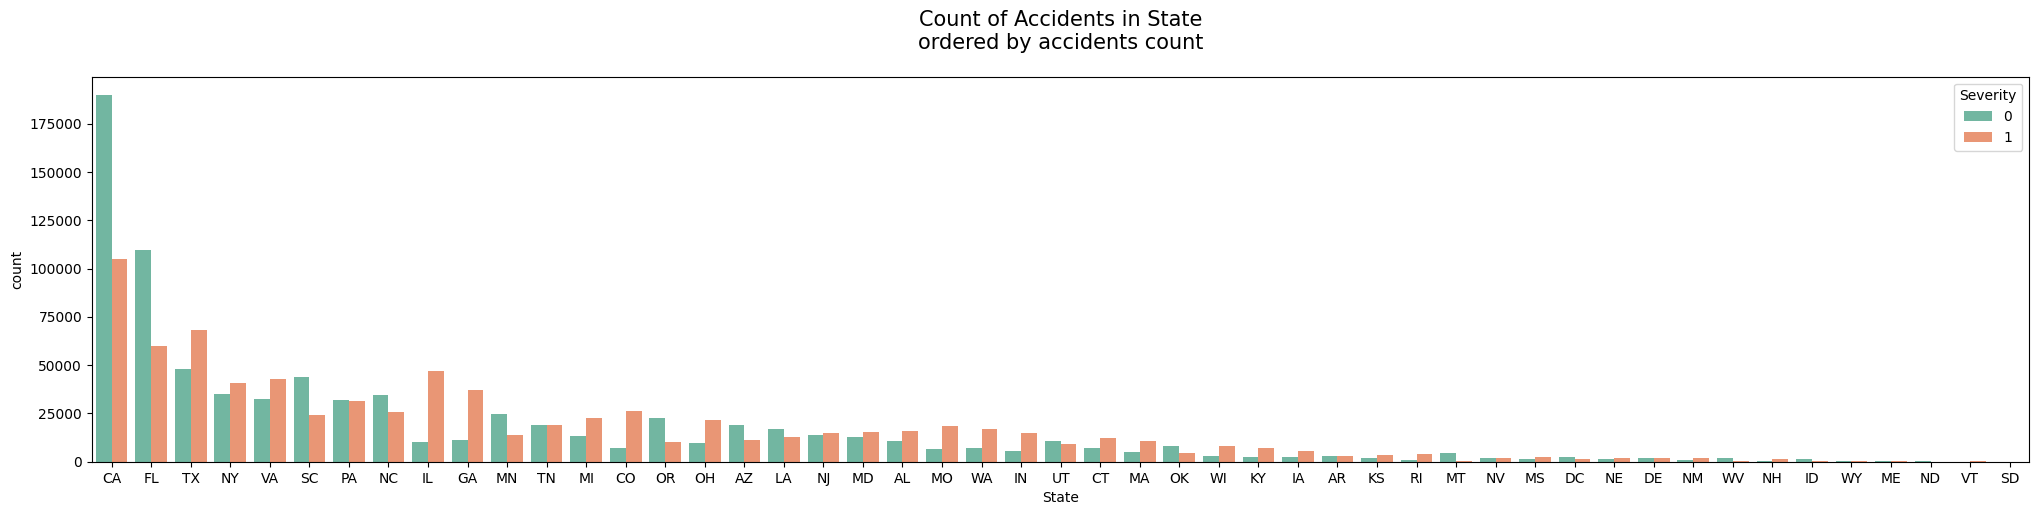

In [32]:
plt.figure(figsize=(25,5))
sns.countplot(x='State', hue='Severity',
                      data=re_df ,palette="Set2", order=re_df['State'].value_counts().index)
plt.title("Count of Accidents in State\nordered by accidents count", size=15, y=1.05)
plt.show()

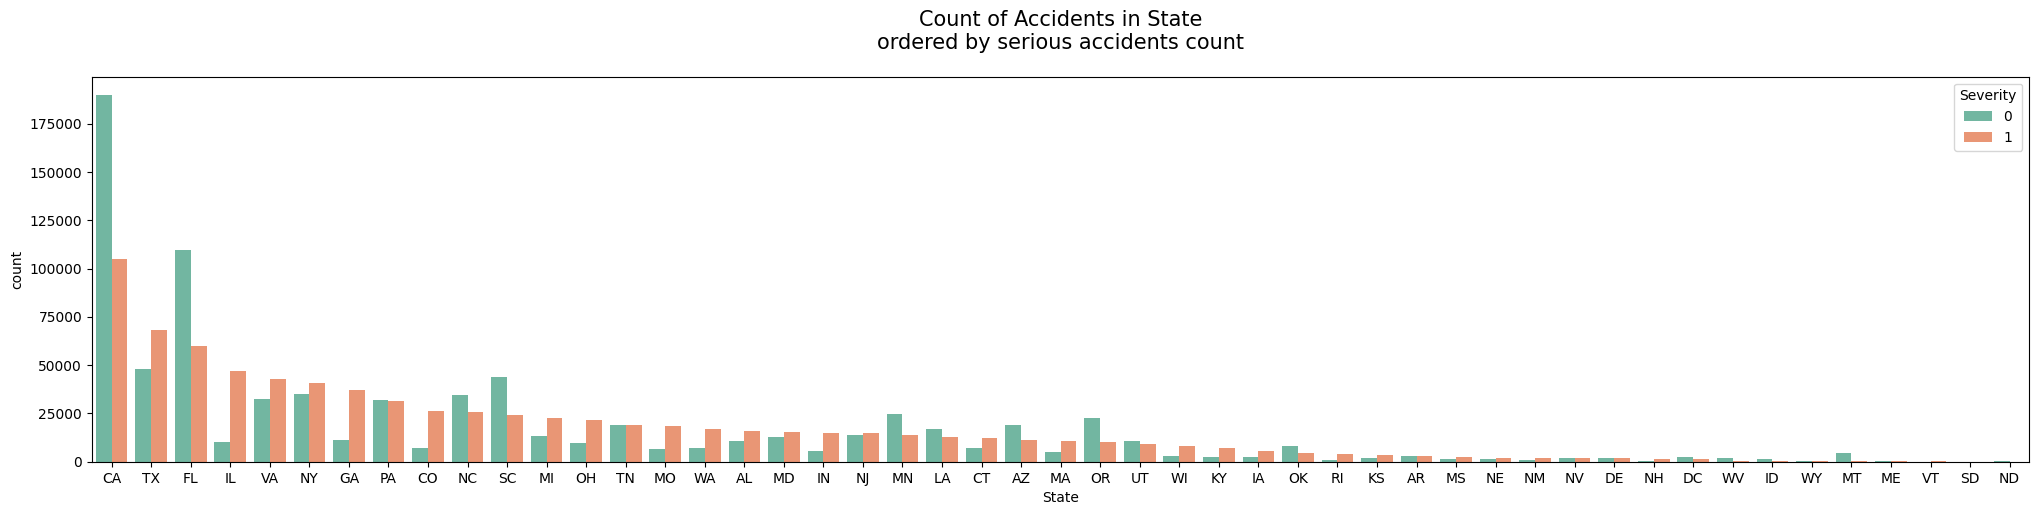

In [33]:
plt.figure(figsize=(25,5))
sns.countplot(x='State', hue='Severity', data=re_df ,palette="Set2", order=re_df[re_df['Severity']==1]['State'].value_counts().index)
plt.title("Count of Accidents in State\nordered by serious accidents count", size=15, y=1.05)
plt.show()

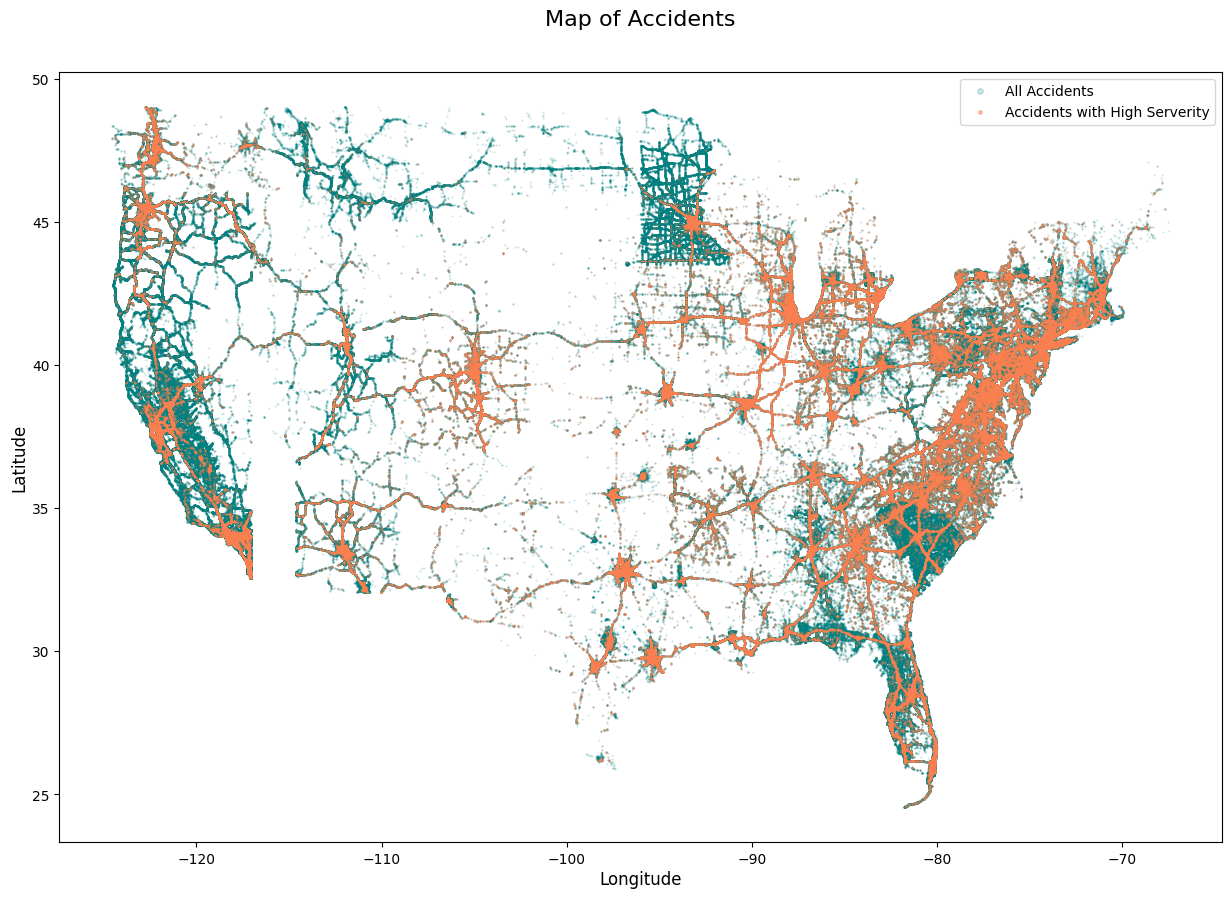

In [34]:
df_4 = data[data['Severity']==1]

plt.figure(figsize=(15,10))

plt.plot( 'Start_Lng', 'Start_Lat', data=data, linestyle='', marker='o', markersize=0.5, color="teal", alpha=0.2, label='All Accidents')
plt.plot( 'Start_Lng', 'Start_Lat', data=df_4, linestyle='', marker='o', markersize=0.3, color="coral", alpha=0.5, label='Accidents with High Serverity')
plt.legend(markerscale=8)
plt.xlabel('Longitude', size=12, labelpad=3)
plt.ylabel('Latitude', size=12, labelpad=3)
plt.title('Map of Accidents', size=16, y=1.05)
plt.show()

## Weather Feature

In [35]:
# extreamly skewed distribution
data['Pressure_bc']= boxcox(data['Pressure(in)'].apply(lambda x: x+1),lmbda=6)
data['Visibility_bc']= boxcox(data['Visibility(mi)'].apply(lambda x: x+1),lmbda = 0.1)
data['Wind_Speed_bc']= boxcox(data['Wind_Speed(mph)'].apply(lambda x: x+1),lmbda=-0.2)
data = data.drop(['Pressure(in)','Visibility(mi)','Wind_Speed(mph)'], axis=1)

re_df = resampleData(data,'Severity',800000)

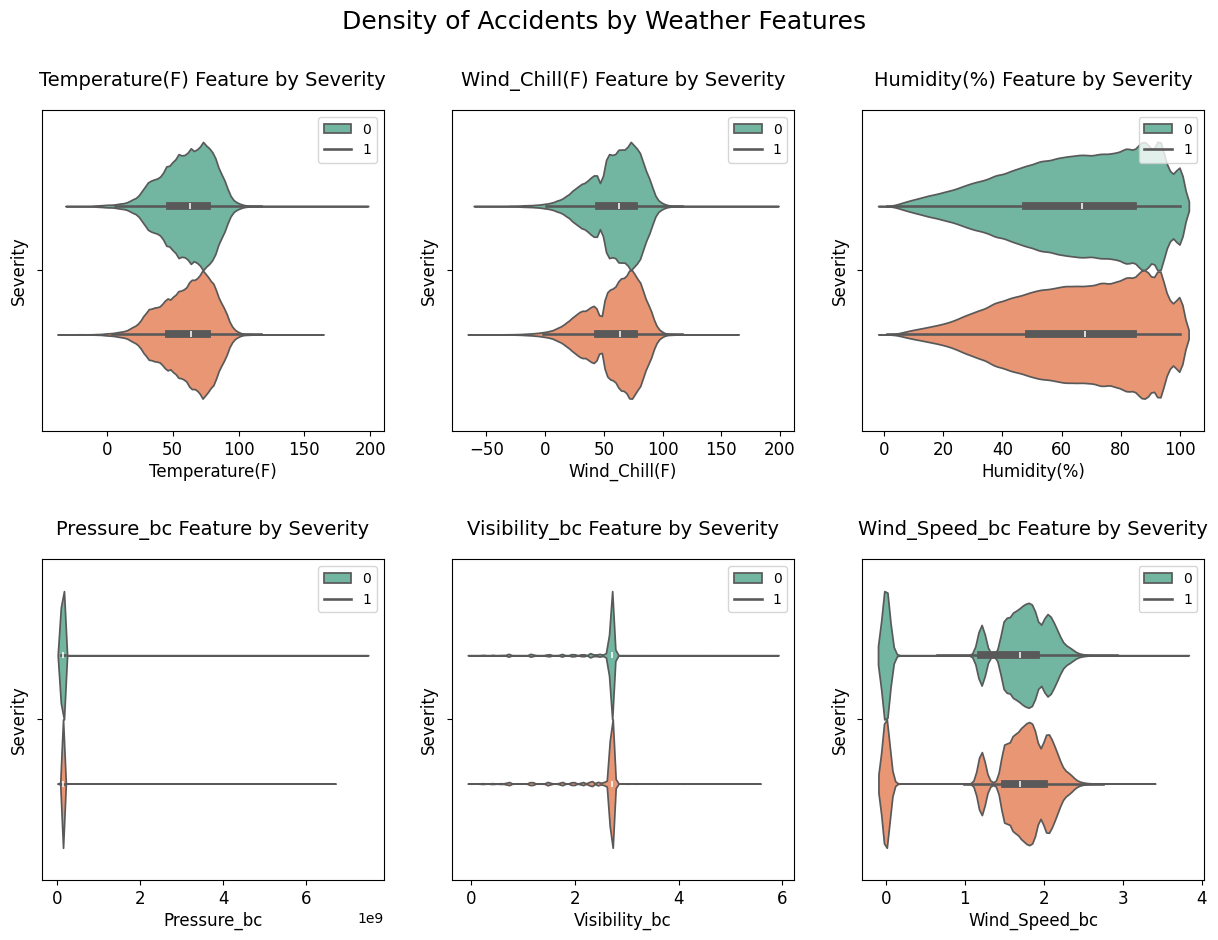

In [36]:
# Assuming `data` is your DataFrame and has 'Weather_Condition' and 'Severity' columns.

num_features = ["Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure_bc","Visibility_bc","Wind_Speed_bc"]

fig, axs = plt.subplots(2,3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4,wspace = 0.2)

axs = axs.flatten()

for i, feature in enumerate(num_features):

    sns.violinplot(ax = axs[i], x=feature, hue="Severity", data=re_df, palette="Set2")

    axs[i].set_xlabel(f'{feature}', size=12, labelpad=3)
    axs[i].set_ylabel('Severity', size=12, labelpad=3)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)

    axs[i].legend(['0', '1'], loc='upper right', prop={'size': 10})
    axs[i].set_title(f'{feature} Feature by Severity', size=14, y=1.05)

fig.suptitle('Density of Accidents by Weather Features', fontsize=18)
plt.show()

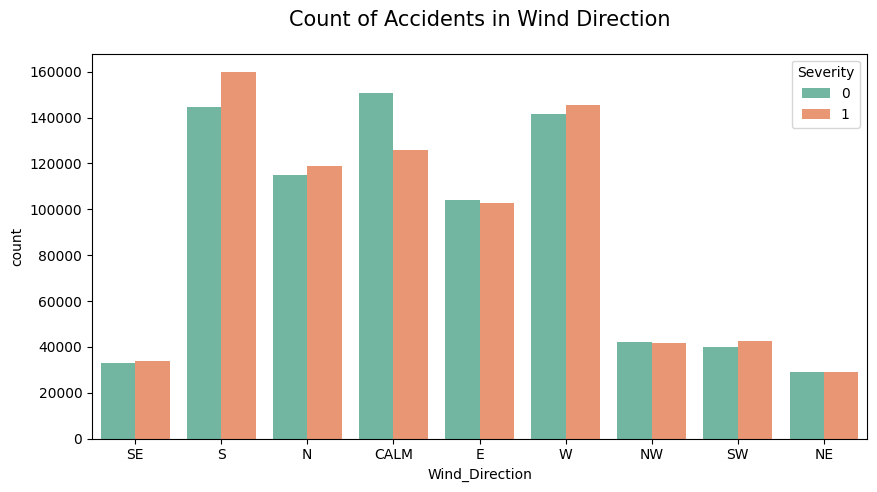

In [37]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x='Wind_Direction', hue='Severity', data=re_df ,palette="Set2")
plt.title("Count of Accidents in Wind Direction", size=15, y=1.05)
plt.show()

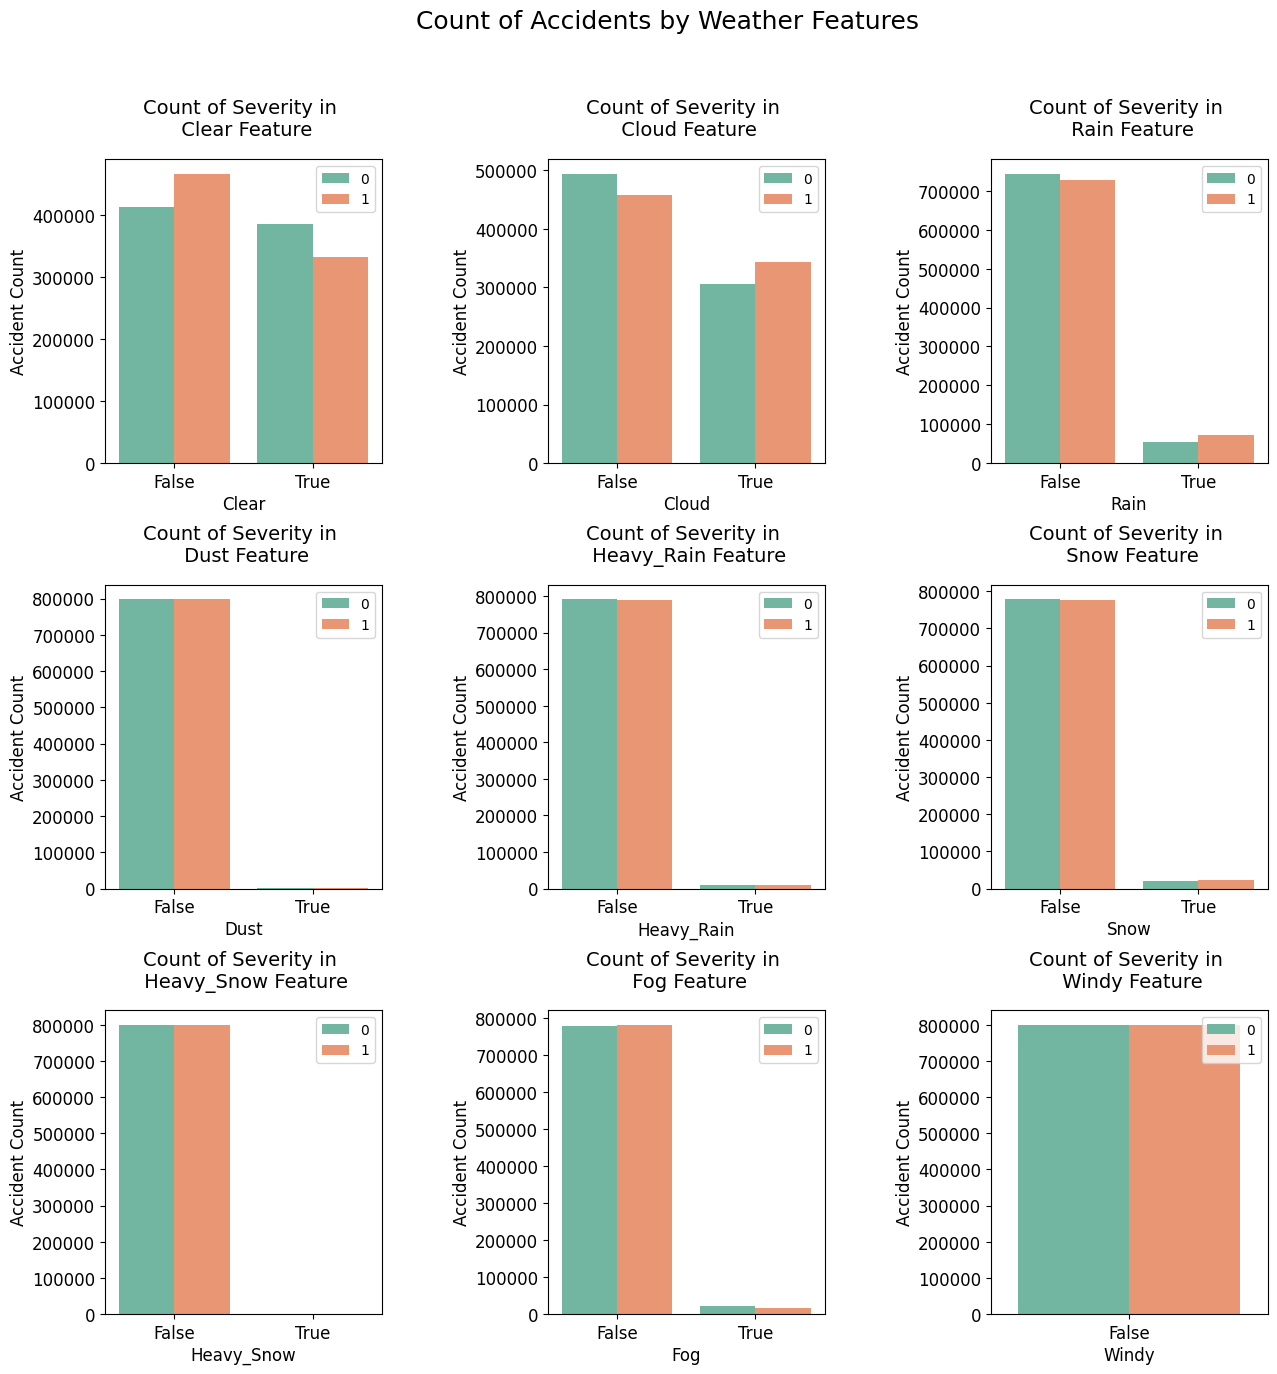

In [38]:
# Assuming `data` is your DataFrame and has 'Weather_Condition' and 'Severity' columns.
weather = ['Clear', 'Cloud', 'Rain', 'Dust', 'Heavy_Rain', 'Snow', 'Heavy_Snow', 'Fog','Windy']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid
plt.subplots_adjust(hspace=0.4, wspace=0.6)      # Adjust spacing

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot for each feature
for i, feature in enumerate(weather):
    # Add a new column to indicate the condition for the feature
    re_df[feature] = re_df['Weather_Condition'] == feature

    # Create a countplot in the current axis
    sns.countplot(ax=axs[i], x=feature, hue='Severity', data=re_df, palette="Set2")

    axs[i].set_xlabel(f'{feature}', size=12, labelpad=3)
    axs[i].set_ylabel('Accident Count', size=12, labelpad=3)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].legend(['0', '1'], loc='upper right', prop={'size': 10})
    axs[i].set_title(f'Count of Severity in \n {feature} Feature', size=14, y=1.05)

    # Drop the column to clean up
    re_df = re_df.drop([feature], axis=1)

# Hide unused subplots
for j in range(len(weather), len(axs)):
    fig.delaxes(axs[j])

# Add a global title
fig.suptitle('Count of Accidents by Weather Features', fontsize=18)
plt.show()

In [39]:
data = data.loc[data['Weather_Condition'] != "Fog"]
data = data.loc[data['Weather_Condition'] != "Windy"]
data = data.loc[data['Weather_Condition'] != "Dust"]

print(data['Severity'].value_counts())

re_df = resampleData(data,'Severity',700000)

Severity
0    4282507
1     671647
Name: count, dtype: int64


## Point Of Interest (POI) Feature

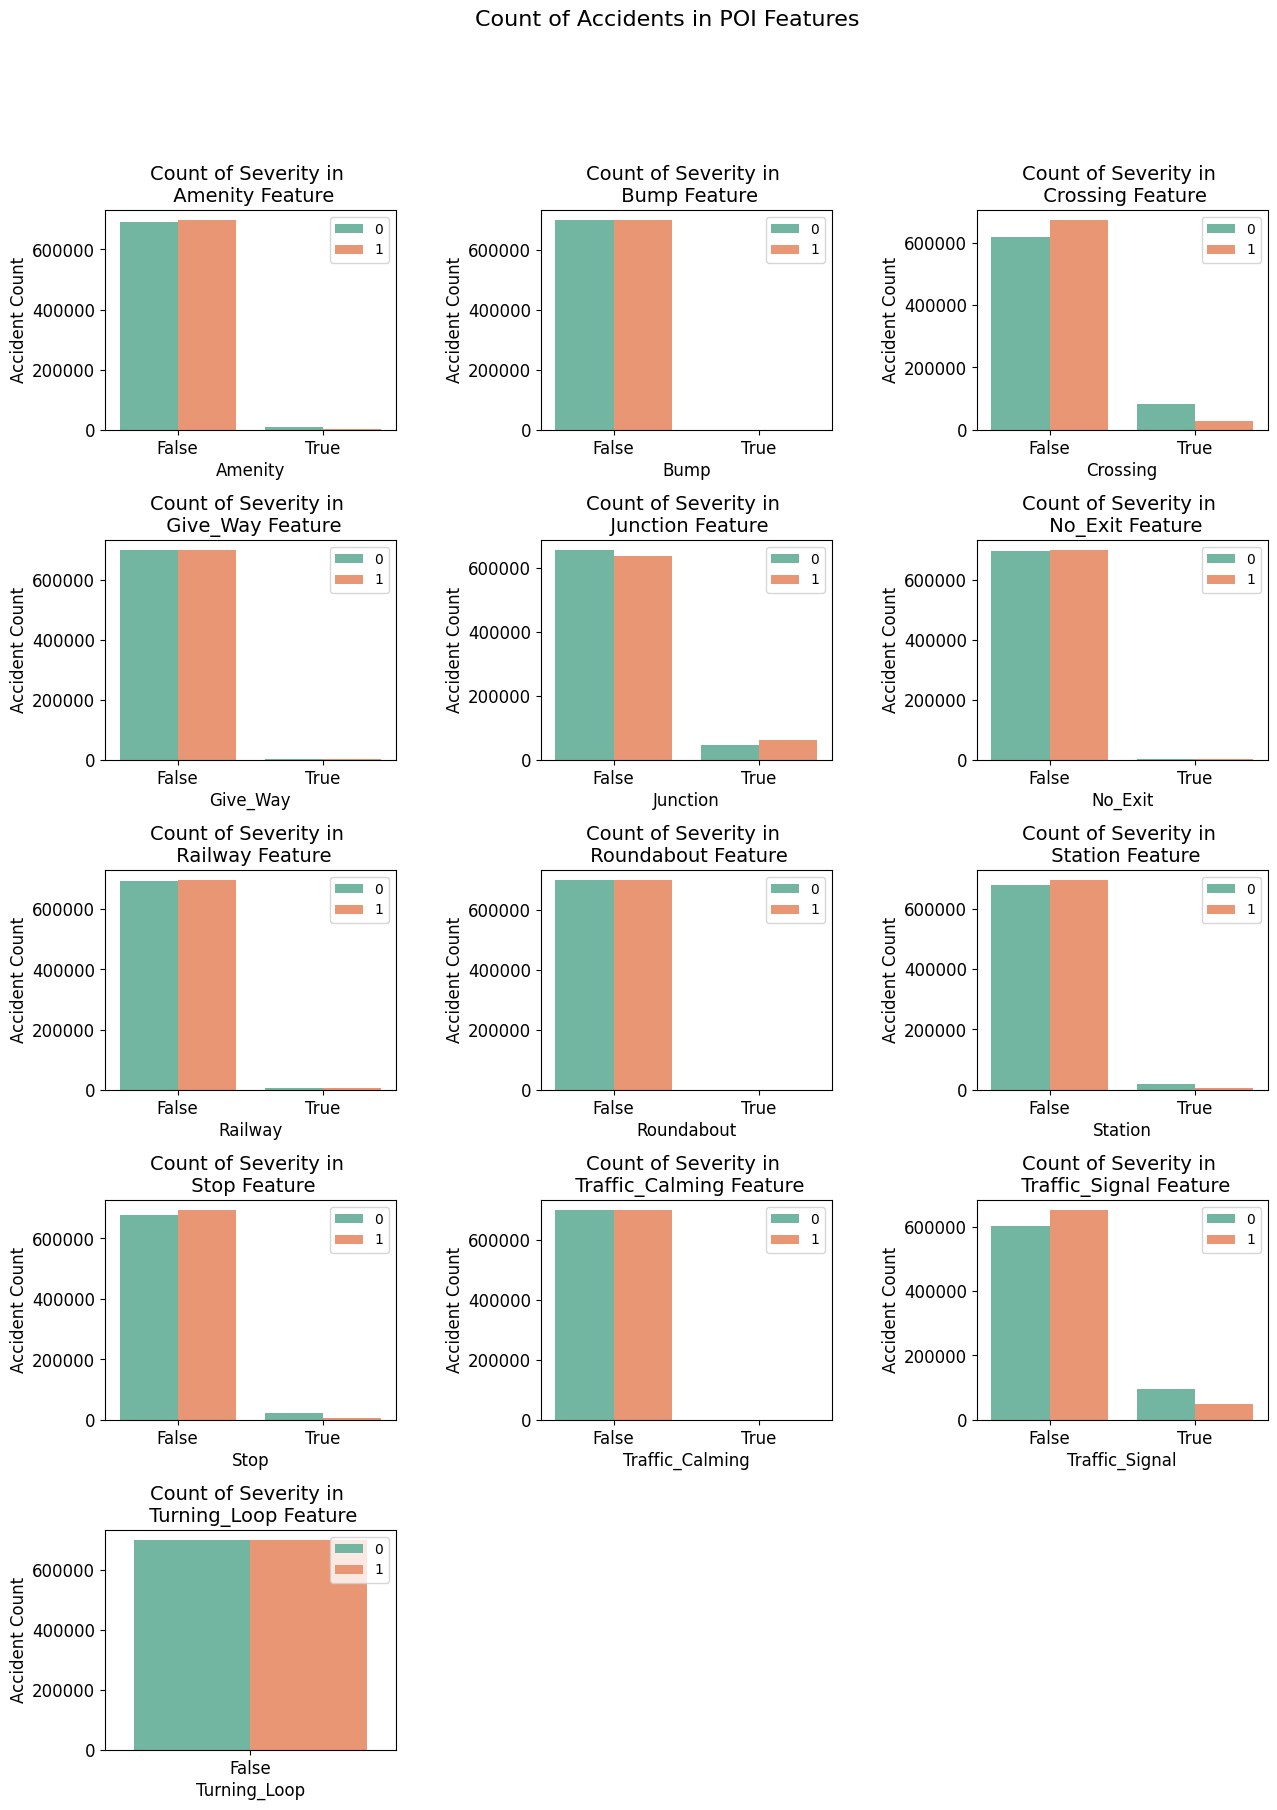

In [40]:
POI_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop']

fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5,wspace = 0.5)

axs = axs.flatten()

for i, feature in enumerate(POI_features):

    sns.countplot(ax=axs[i], x=feature, hue='Severity', data=re_df, palette="Set2")

    axs[i].set_xlabel(f'{feature}', size=12, labelpad=3)
    axs[i].set_ylabel('Accident Count', size=12, labelpad=3)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].legend(['0', '1'], loc='upper right', prop={'size': 10})
    axs[i].set_title(f'Count of Severity in \n {feature} Feature', size=14)

# Hide unused subplots
for j in range(len(POI_features), len(axs)):
    fig.delaxes(axs[j])

fig.suptitle('Count of Accidents in POI Features', fontsize=16)
plt.show()

In [41]:
data = data.drop(['Amenity','Bump','Give_Way',"No_Exit","Railway","Roundabout","Traffic_Calming","Turning_Loop"], axis  = 1)

## Correlation

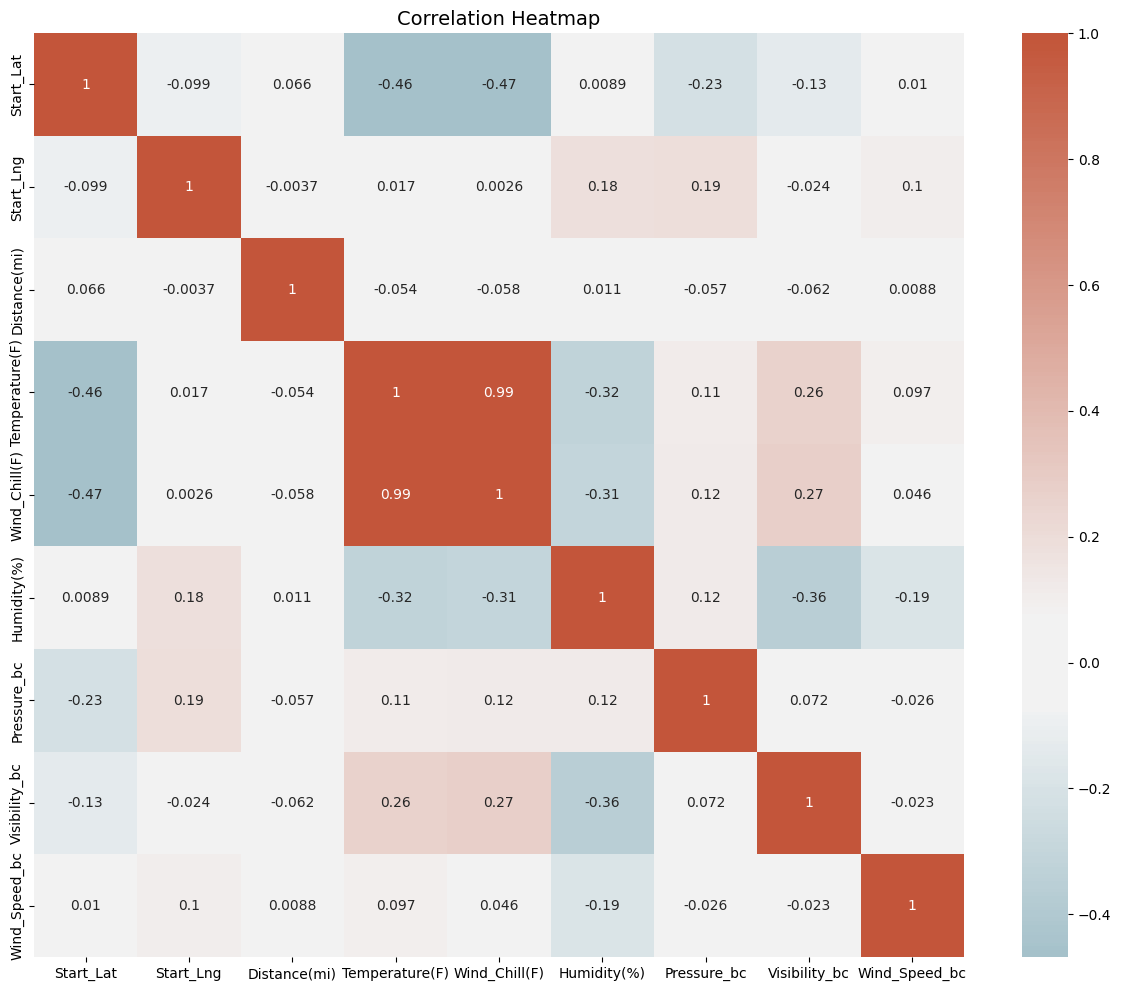

In [42]:
continous_data = data[["Start_Lat","Start_Lng","Distance(mi)","Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure_bc","Visibility_bc","Wind_Speed_bc"]]

data['Severity'] = data['Severity'].astype(int)
plt.figure(figsize=(15,12))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(continous_data.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=14)
plt.show()

In [43]:
data = data.drop(['Wind_Chill(F)'],axis=1)

# Model

In [44]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score

In [45]:
data = data.replace([True, False], [1,0])

encoder = LabelEncoder()

categories_features = ['State','Timezone','Wind_Direction','Weather_Condition','Sunrise_Sunset',]

for feature in categories_features:
  data[feature] = encoder.fit_transform(data[feature])

C:\Users\Admin\AppData\Local\Temp\ipykernel_2988\2877595321.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace([True, False], [1,0])


In [47]:
def getResult(y_test,y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print('Accuracy:',accuracy)
  print('Precision:',precision)
  print('Recall:', recall)
  print('F1 score:',f1)
  print('Confusion matrix:')
  print(confusion_matrix(y_test, y_pred))
  return [accuracy,precision,recall,f1]

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4954154 entries, 512217 to 7728393
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   State              int64  
 5   Timezone           int64  
 6   Temperature(F)     float64
 7   Humidity(%)        float64
 8   Wind_Direction     int64  
 9   Weather_Condition  int64  
 10  Crossing           int64  
 11  Junction           int64  
 12  Station            int64  
 13  Stop               int64  
 14  Traffic_Signal     int64  
 15  Sunrise_Sunset     int64  
 16  Year               int32  
 17  Month              int32  
 18  Day                int32  
 19  Hour               int32  
 20  Week               int32  
 21  Pressure_bc        float64
 22  Visibility_bc      float64
 23  Wind_Speed_bc      float64
dtypes: float64(8), int32(5), int64(11)
memory usage: 8

In [49]:
# split X, y
X = data.drop('Severity', axis=1)
y= data['Severity']

X = StandardScaler().fit_transform(X)
# split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## LogisticRegression

In [50]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [51]:
lr_result = ['Logistic Regression'] + getResult(y_test,y_pred)

Accuracy: 0.8652565825195947
Precision: 0.5251777889519431
Recall: 0.03637983111318999
F1 score: 0.06804601552465517
Confusion matrix:
[[1278674    6610]
 [ 193652    7311]]


## Naive Bayes

In [52]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)

In [53]:
nb_result = ['Naive Bayes'] + getResult(y_test,y_pred)

Accuracy: 0.7219028869360208
Precision: 0.2464369979080497
Recall: 0.5135024855321626
F1 score: 0.3330423374766625
Confusion matrix:
[[969731 315553]
 [ 97768 103195]]


## Decision Tree

In [54]:
dstree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2, random_state=42)
dstree.fit(X_train, y_train)
y_pred = dstree.predict(X_test)

In [55]:
dstree_result = ['Decision Tree'] + getResult(y_test,y_pred)

Accuracy: 0.8923099592463433
Precision: 0.6816579188092257
Recall: 0.38193100222429005
F1 score: 0.4895618729310312
Confusion matrix:
[[1249439   35845]
 [ 124209   76754]]


## Random Forest

In [56]:
rf = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_split=2, n_estimators = 10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [57]:
rf_result = ['Random Forest'] + getResult(y_test,y_pred)

Accuracy: 0.8819590552579752
Precision: 0.780784546674587
Recall: 0.1765946965361783
F1 score: 0.28804136095058763
Confusion matrix:
[[1275320    9964]
 [ 165474   35489]]


# Summary

In [58]:
result = pd.DataFrame(data= [lr_result,nb_result,dstree_result,rf_result],columns=['Model','Accuracy','Precision','Recall','F1'])
result

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.865257,0.525178,0.036380,0.068046
1,Naive Bayes,0.721903,0.246437,0.513502,0.333042
2,Decision Tree,0.892310,0.681658,0.381931,0.489562
3,Random Forest,0.881959,0.780785,0.176595,0.288041
